# Example climb: Feature interactions with weak individual correlations

## 1. Notebook setup

### 1.1. Imports

In [1]:
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

sys.path.append('..')

from hill_climber import HillClimber

### 1.2. Run hyperparameters

In [2]:
# Number of input data points
n = 1000

# Run duration in minutes
run_time = 30

# Number of replicate climbs for each objective function
replicates = 4

# Hill climb parameters
step_size = 0.05
perturb_fraction = 0.05
temperature = 1000
initial_noise = 0.2
cooling_rate = 0.9999

### 1.3. Input distributions

In [3]:
# Create input distributions: 3 features (x1, x2, x3) and 1 label (y)
# Start with a dataset that HAS some structure but weak individual correlations
np.random.seed(42)

# Create features with some inherent structure
x1_base = np.random.uniform(0, 10, n)
x2_base = np.random.uniform(0, 10, n)
x3_base = np.random.uniform(0, 10, n)

# Create label with weak individual correlations but potential for interactions
# y = small_effect1*x1 + small_effect2*x2 + small_effect3*x3 + noise
noise_factor = 3.0
y_base = (0.1 * x1_base + 0.15 * x2_base + 0.12 * x3_base + 
          noise_factor * np.random.uniform(0, 10, n))

data = pd.DataFrame({
    'x1': x1_base,
    'x2': x2_base,
    'x3': x3_base,
    'y': y_base
})

print("Initial data statistics:")
print(data.describe())
print("\nInitial correlations with label:")

for col in ['x1', 'x2', 'x3']:
    corr, _ = pearsonr(data[col], data['y'])
    print(f"{col}-y: {corr:.4f}")

# Check initial linear regression R²
X = data[['x1', 'x2', 'x3']].values
y = data['y'].values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
print(f"\nInitial Multiple Linear Regression R²: {r2:.4f}")

Initial data statistics:
                x1           x2           x3            y
count  1000.000000  1000.000000  1000.000000  1000.000000
mean      4.902566     5.070173     5.024057    16.564921
std       2.921374     2.921899     2.906742     8.603125
min       0.046320     0.032183     0.000116     0.890684
25%       2.359733     2.410743     2.613510     9.147097
50%       4.968074     5.187339     5.006139    16.368372
75%       7.443196     7.604651     7.591035    23.958081
max       9.997177     9.994137     9.978209    32.537602

Initial correlations with label:
x1-y: 0.0066
x2-y: 0.0473
x3-y: 0.0289

Initial Multiple Linear Regression R²: 0.0030


## 2. Optimize for weak individual correlations but strong collective prediction

### 2.1. Objective function

In [4]:
def objective_feature_interactions(x1, x2, x3, y):
    '''Maximize multiple linear regression R² while minimizing individual feature-label correlations.
    
    This creates datasets where features interact to predict the label, but individual features
    alone are poor predictors. This demonstrates the importance of feature interactions.
    
    Args:
        x1, x2, x3: Feature variables (array-like)
        y: Label variable (array-like)
    
    Returns:
        Tuple of (metrics_dict, objective_value)
    '''
    
    # Convert to numpy arrays
    x1 = np.asarray(x1)
    x2 = np.asarray(x2)
    x3 = np.asarray(x3)
    y = np.asarray(y)
    
    # Validation
    if len(x1) < 10 or len(x1) != len(x2) or len(x1) != len(x3) or len(x1) != len(y):
        return {'error': 'invalid_input'}, -1000.0
    
    try:
        # Calculate individual Pearson correlations with label
        corr_x1_y, _ = pearsonr(x1, y)
        corr_x2_y, _ = pearsonr(x2, y)
        corr_x3_y, _ = pearsonr(x3, y)
        
        # Handle NaN correlations
        if np.isnan(corr_x1_y):
            corr_x1_y = 0.0
        if np.isnan(corr_x2_y):
            corr_x2_y = 0.0
        if np.isnan(corr_x3_y):
            corr_x3_y = 0.0
        
        # Average absolute correlation (want this LOW)
        avg_individual_corr = np.mean([abs(corr_x1_y), abs(corr_x2_y), abs(corr_x3_y)])
        max_individual_corr = np.max([abs(corr_x1_y), abs(corr_x2_y), abs(corr_x3_y)])
        
    except Exception as e:
        avg_individual_corr = 0.0
        max_individual_corr = 0.0
        corr_x1_y = 0.0
        corr_x2_y = 0.0
        corr_x3_y = 0.0
    
    try:

        # Calculate multiple linear regression R² (want this HIGH)
        X = np.column_stack([x1, x2, x3])
        
        # Check for valid variance
        if np.std(y) < 1e-6:
            mlr_r2 = 0.0

        else:
            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            mlr_r2 = r2_score(y, y_pred)
            
            # Clip R² to valid range
            mlr_r2 = np.clip(mlr_r2, -1.0, 1.0)
            
    except Exception as e:
        mlr_r2 = 0.0
    
    try:
        # Calculate pairwise feature correlations (want moderate values for diversity)
        corr_x1_x2, _ = pearsonr(x1, x2)
        corr_x1_x3, _ = pearsonr(x1, x3)
        corr_x2_x3, _ = pearsonr(x2, x3)
        
        # Handle NaN
        if np.isnan(corr_x1_x2):
            corr_x1_x2 = 0.0

        if np.isnan(corr_x1_x3):
            corr_x1_x3 = 0.0

        if np.isnan(corr_x2_x3):
            corr_x2_x3 = 0.0
        
        avg_feature_corr = np.mean([abs(corr_x1_x2), abs(corr_x1_x3), abs(corr_x2_x3)])
        
    except Exception as e:
        corr_x1_x2 = 0.0
        corr_x1_x3 = 0.0
        corr_x2_x3 = 0.0
        avg_feature_corr = 0.0
    
    # Penalty for high individual correlations with label
    individual_corr_penalty = 15.0 * avg_individual_corr
    
    # Penalty for extremely high max individual correlation
    max_corr_penalty = 10.0 * max(0, max_individual_corr - 0.25)  # Penalize if > 0.25
    
    # Reward for high MLR R² (much stronger weight)
    mlr_reward = 50.0 * max(0, mlr_r2)  # Strong reward for positive R²
    
    # Bonus reward for achieving high R² with low individual correlations
    if mlr_r2 > 0.3 and avg_individual_corr < 0.3:
        bonus = 20.0 * (mlr_r2 - avg_individual_corr)

    else:
        bonus = 0.0
    
    # Penalty for extreme feature intercorrelations (want moderate correlation)
    # Features should have some relationship for interactions
    feature_corr_penalty = 0.0

    if avg_feature_corr > 0.85:  # Too correlated
        feature_corr_penalty = 5.0 * (avg_feature_corr - 0.85)

    elif avg_feature_corr < 0.05:  # Too independent (hard to create interactions)
        feature_corr_penalty = 3.0 * (0.05 - avg_feature_corr)
    
    # Calculate objective: maximize MLR R², minimize individual correlations
    objective = mlr_reward + bonus - individual_corr_penalty - max_corr_penalty - feature_corr_penalty
    
    # Compile metrics
    metrics = {
        'MLR R²': float(mlr_r2),
        'Avg Individual Corr': float(avg_individual_corr),
        'Max Individual Corr': float(max_individual_corr),
        'Corr x1-y': float(corr_x1_y),
        'Corr x2-y': float(corr_x2_y),
        'Corr x3-y': float(corr_x3_y),
        'Avg Feature Corr': float(avg_feature_corr),
        'Corr x1-x2': float(corr_x1_x2),
        'Corr x1-x3': float(corr_x1_x3),
        'Corr x2-x3': float(corr_x2_x3),
        'Individual Corr Penalty': float(individual_corr_penalty),
        'MLR Reward': float(mlr_reward),
        'Bonus': float(bonus)
    }
    
    return metrics, float(objective)

### 2.2. Hill climbing run

In [5]:
# Create HillClimber instance
climber = HillClimber(
    data=data,
    objective_func=objective_feature_interactions,
    max_time=run_time,
    step_size=step_size,
    perturb_fraction=perturb_fraction,
    temperature=temperature,
    cooling_rate=cooling_rate,
    mode='maximize'
)

# Run parallel optimization
results = climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

### 2.3. Results

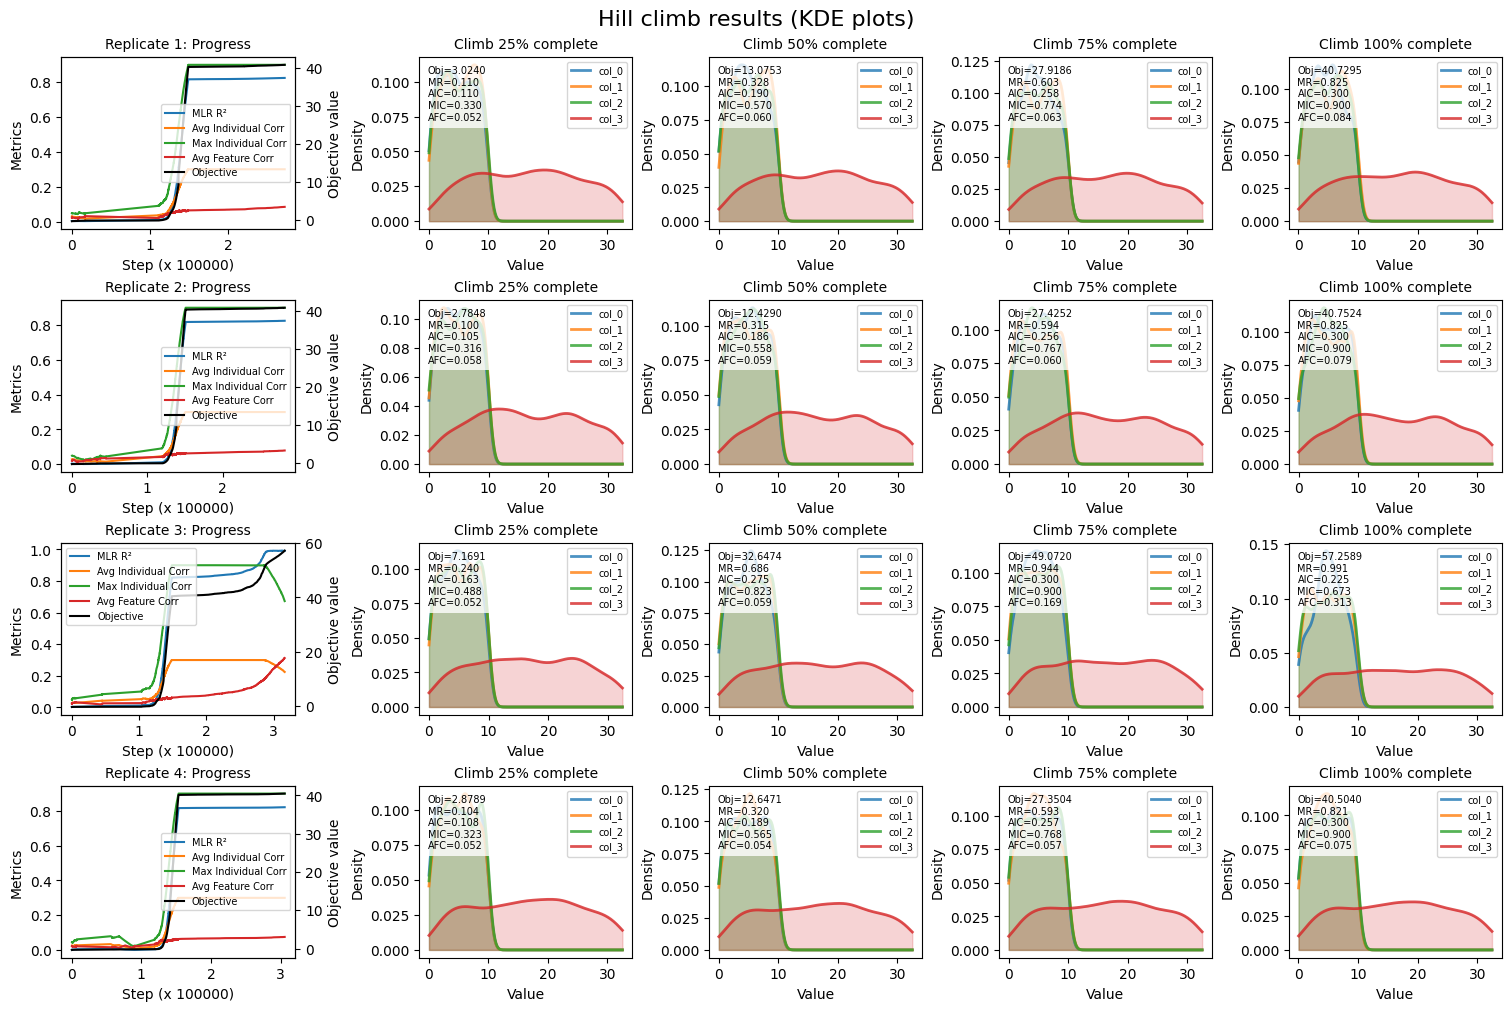

In [6]:
# Display key metrics
climber.plot_results(
    results,
    plot_type='histogram',
    metrics=[
        'MLR R²',
        'Avg Individual Corr',
        'Max Individual Corr',
        'Avg Feature Corr'
    ]
)

### 2.4. Best result analysis

In [7]:
# Analyze the best result
print("="*60)
print("BEST RESULT ANALYSIS")
print("="*60)

# Find the replicate with highest objective value
best_idx = np.argmax([steps_df['Objective value'].iloc[-1] 
                      for _, _, steps_df in results['results']])
noisy_initial_best, best_data_final, best_steps = results['results'][best_idx]

print(f"Best replicate: {best_idx + 1}")
print(f"Final objective: {best_steps['Objective value'].iloc[-1]:.4f}")
print()

# Extract best features and label
X_best = best_data_final[['x1', 'x2', 'x3']].values
y_best = best_data_final['y'].values

# Individual correlations
print("Individual feature-label correlations (want LOW):")
for col in ['x1', 'x2', 'x3']:
    corr, p_val = pearsonr(best_data_final[col], best_data_final['y'])
    print(f"  {col}-y: {corr:7.4f} (p={p_val:.4f})")

avg_corr = np.mean([abs(pearsonr(best_data_final[col], best_data_final['y'])[0]) 
                    for col in ['x1', 'x2', 'x3']])
print(f"  Average: {avg_corr:7.4f}")
print()

# Feature intercorrelations
print("Feature-feature correlations:")
corr_x1_x2, _ = pearsonr(best_data_final['x1'], best_data_final['x2'])
corr_x1_x3, _ = pearsonr(best_data_final['x1'], best_data_final['x3'])
corr_x2_x3, _ = pearsonr(best_data_final['x2'], best_data_final['x3'])
print(f"  x1-x2: {corr_x1_x2:7.4f}")
print(f"  x1-x3: {corr_x1_x3:7.4f}")
print(f"  x2-x3: {corr_x2_x3:7.4f}")
print()

# Multiple Linear Regression
print("Multiple Linear Regression (want HIGH R²):")
model_best = LinearRegression()
model_best.fit(X_best, y_best)
y_pred_best = model_best.predict(X_best)
r2_best = r2_score(y_best, y_pred_best)

print(f"  R² Score: {r2_best:.4f}")
print(f"  Coefficients: {model_best.coef_}")
print(f"  Intercept: {model_best.intercept_:.4f}")
print()

# Calculate what R² would be for each feature alone
print("Individual feature regression R² (for comparison):")
for i, col in enumerate(['x1', 'x2', 'x3']):
    X_single = best_data_final[[col]].values
    model_single = LinearRegression()
    model_single.fit(X_single, y_best)
    y_pred_single = model_single.predict(X_single)
    r2_single = r2_score(y_best, y_pred_single)
    print(f"  {col} alone: {r2_single:.4f}")

print()
print(f"Improvement factor: {r2_best / max(0.001, avg_corr**2):.2f}x")
print("(MLR R² vs. avg squared individual correlation)")

BEST RESULT ANALYSIS
Best replicate: 3
Final objective: 57.2589

Individual feature-label correlations (want LOW):
  x1-y:  0.6731 (p=0.0000)
  x2-y:  0.0002 (p=0.9940)
  x3-y: -0.0003 (p=0.9926)
  Average:  0.2245

Feature-feature correlations:
  x1-x2:  0.6966
  x1-x3:  0.2376
  x2-x3: -0.0035

Multiple Linear Regression (want HIGH R²):
  R² Score: 0.9907
  Coefficients: [ 5.08329438 -3.16026178 -1.07038607]
  Intercept: 12.1252

Individual feature regression R² (for comparison):
  x1 alone: 0.4530
  x2 alone: 0.0000
  x3 alone: 0.0000

Improvement factor: 19.65x
(MLR R² vs. avg squared individual correlation)


### 2.5. Visualization

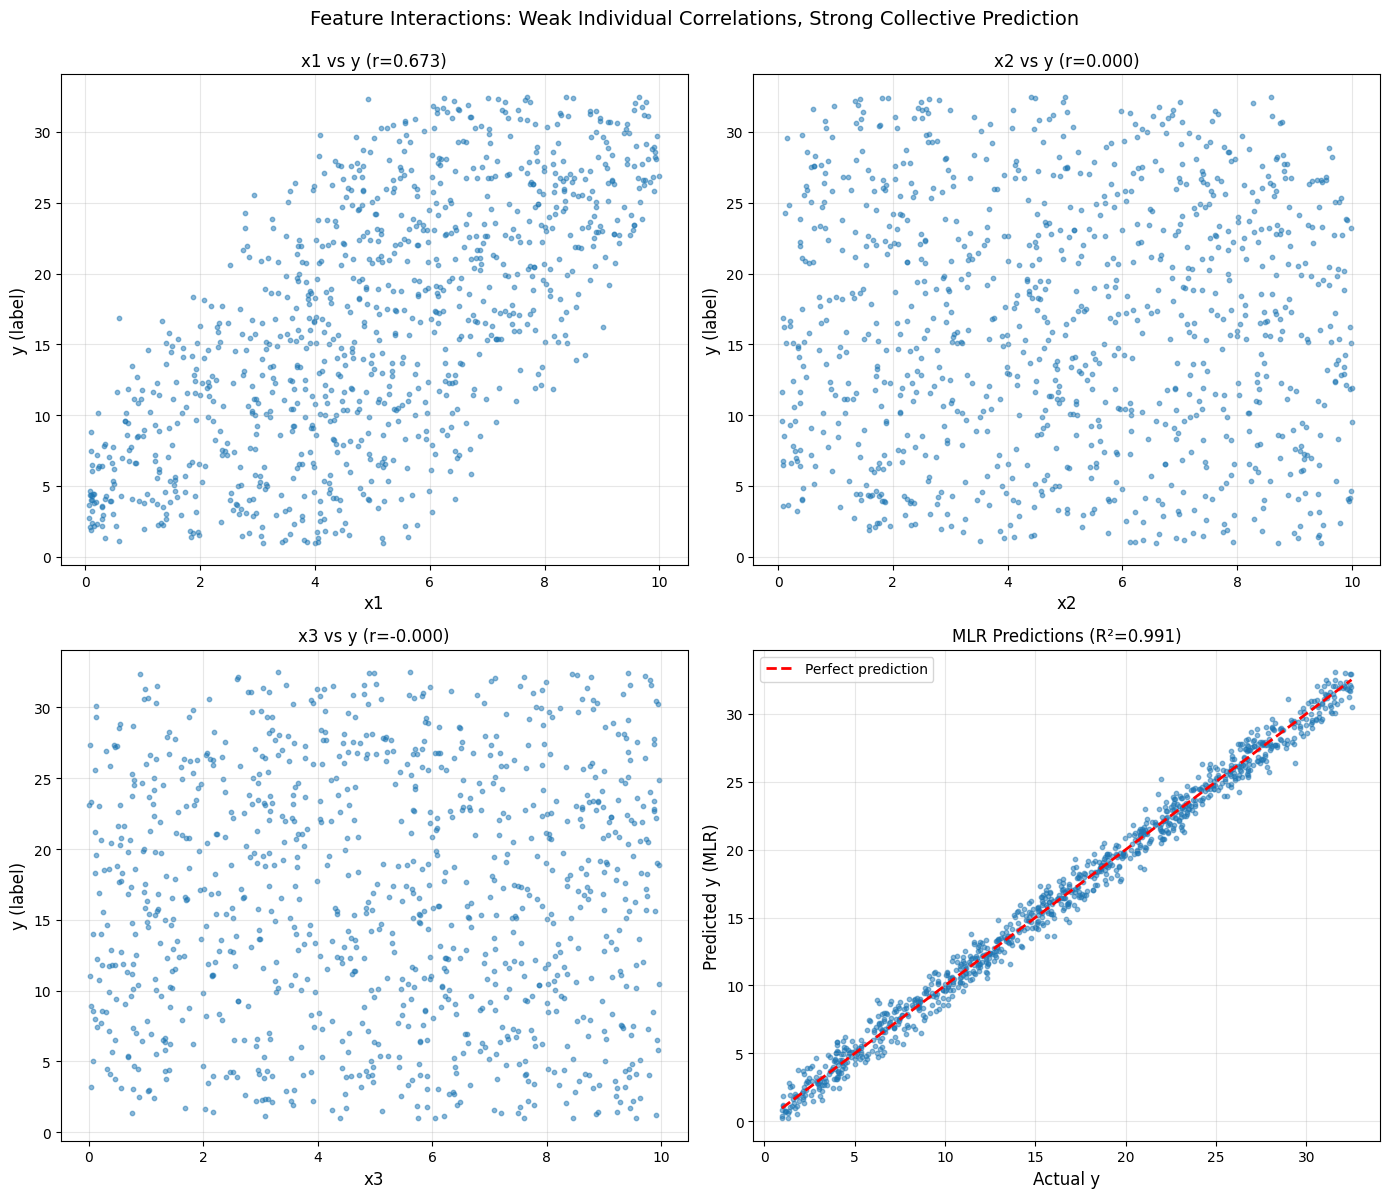

In [8]:
# Visualize feature-label relationships and predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Individual feature plots
for i, col in enumerate(['x1', 'x2', 'x3']):
    ax = axes[i // 2, i % 2]
    ax.scatter(best_data_final[col], y_best, s=10, alpha=0.5)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('y (label)', fontsize=12)
    
    # Add correlation to title
    corr, _ = pearsonr(best_data_final[col], y_best)
    ax.set_title(f'{col} vs y (r={corr:.3f})', fontsize=12)
    ax.grid(True, alpha=0.3)

# Predicted vs actual
ax = axes[1, 1]
ax.scatter(y_best, y_pred_best, s=10, alpha=0.5)
ax.plot([y_best.min(), y_best.max()], [y_best.min(), y_best.max()], 
        'r--', lw=2, label='Perfect prediction')
ax.set_xlabel('Actual y', fontsize=12)
ax.set_ylabel('Predicted y (MLR)', fontsize=12)
ax.set_title(f'MLR Predictions (R²={r2_best:.3f})', fontsize=12)
ax.legend()
ax.grid(True, alpha=0.3)

fig.suptitle('Feature Interactions: Weak Individual Correlations, Strong Collective Prediction', 
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

In [9]:
# Save the climber object
with open('../data/06_feature_interactions.pkl', 'wb') as f:
    pickle.dump(climber, f)

## 3. Resume optimization for additional hour

### 3.1. Load saved climber and resume

In [ ]:
# Load the saved climber object
with open('../data/06_feature_interactions.pkl', 'rb') as f:
    loaded_climber = pickle.load(f)

# Resume optimization for an additional 60 minutes
print("Resuming optimization for an additional 60 minutes...")
print(f"Previous run time: {loaded_climber.max_time} minutes")
print(f"Additional run time: 60 minutes")
print()

# Update max_time for the additional 60 minutes
loaded_climber.max_time = 60

# Continue the optimization
resumed_results = loaded_climber.climb_parallel(
    replicates=replicates,
    initial_noise=initial_noise
)

Resuming optimization for an additional 60 minutes...
Previous run time: 30 minutes
Additional run time: 60 minutes



In [ ]:
# Display key metrics from resumed optimization
loaded_climber.plot_results(
    resumed_results,
    metrics=[
        'Individual Correlation Penalty',
        'MLR R² Score',
        'Max Individual Correlation',
        'Mean Individual Correlation'
    ]
)

In [ ]:
# Save the resumed climber object
with open('../data/06_feature_interactions_resumed.pkl', 'wb') as f:
    pickle.dump(loaded_climber, f)

print("Resumed results saved to '../data/06_feature_interactions_resumed.pkl'")